<a href="https://colab.research.google.com/github/DonaldTurton/AT2_Advanced_Data_Algorithms/blob/master/AT2_GetData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Predicting Energy Prices

In [0]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #Data Visualization
import seaborn as sns #Correlation plot
from google.colab import files

# Libraries for XGBOOST
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer


In [0]:
# Read csv
url = 'https://raw.githubusercontent.com/DonaldTurton/AT2_Advanced_Data_Algorithms/master/Clean_Data.csv'
data = pd.read_csv(url)
data.head()

,Unnamed: 0,Year.x,Month,Day,TOTALDEMAND,RRP,date_keep,time_keep,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,Season,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,segment_day,week_of_year,day_of_week,segment_30min,index,lagprice
0,0,2018,1,1,NaN,91.86,2018/01/01,00:30:00,31.0,20.8,28.3,0.0,1,NaN,NaN,NaN,NaN,1,1,Monday,2,1,NaN
1,1,2018,1,1,6912.25,88.83,2018/01/01,01:00:00,31.0,20.8,28.3,0.0,1,NaN,NaN,NaN,NaN,1,1,Monday,3,2,91.86
2,2,2018,1,1,6745.63,73.62,2018/01/01,01:30:00,31.0,20.8,28.3,0.0,1,90.345,NaN,6828.940,NaN,1,1,Monday,4,3,88.83
3,3,2018,1,1,6466.06,71.49,2018/01/01,02:00:00,31.0,20.8,28.3,0.0,1,81.225,NaN,6605.845,NaN,1,1,Monday,5,4,73.62
4,4,2018,1,1,6279.80,69.27,2018/01/01,02:30:00,31.0,20.8,28.3,0.0,1,72.555,81.45,6372.930,6600.935,1,1,Monday,6,5,71.49


In [0]:
# LAGG Total Demand by 30 mins 
data['TOTALDEMAND'] = data['TOTALDEMAND'].shift(1)
data.head()

,Unnamed: 0,Year.x,Month,Day,TOTALDEMAND,RRP,date_keep,time_keep,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,Season,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,segment_day,week_of_year,day_of_week,segment_30min,index,lagprice
0,0,2018,1,1,NaN,91.86,2018/01/01,00:30:00,31.0,20.8,28.3,0.0,1,NaN,NaN,NaN,NaN,1,1,Monday,2,1,NaN
1,1,2018,1,1,NaN,88.83,2018/01/01,01:00:00,31.0,20.8,28.3,0.0,1,NaN,NaN,NaN,NaN,1,1,Monday,3,2,91.86
2,2,2018,1,1,6912.25,73.62,2018/01/01,01:30:00,31.0,20.8,28.3,0.0,1,90.345,NaN,6828.940,NaN,1,1,Monday,4,3,88.83
3,3,2018,1,1,6745.63,71.49,2018/01/01,02:00:00,31.0,20.8,28.3,0.0,1,81.225,NaN,6605.845,NaN,1,1,Monday,5,4,73.62
4,4,2018,1,1,6466.06,69.27,2018/01/01,02:30:00,31.0,20.8,28.3,0.0,1,72.555,81.45,6372.930,6600.935,1,1,Monday,6,5,71.49


In [0]:
# Update the moving average variables

data.demand_mov_avg_1hr = data.TOTALDEMAND.rolling(window=2).mean()
data.demand_mov_avg_2hr = data.TOTALDEMAND.rolling(window=4).mean()

data.head()

# Create a new price variable with one unit lag (predicting current price will be influenced by the previous periods price)

data['lagprice'] = data.RRP.shift(1)

data.head()

# Create moving average variables for 1hr and 2hrs in python

data.price_mov_avg_1hr = data.lagprice.rolling(window=2).mean()
data.price_mov_avg_2hr = data.lagprice.rolling(window=4).mean()

data.head()

,Unnamed: 0,Year.x,Month,Day,TOTALDEMAND,RRP,date_keep,time_keep,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,Season,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,segment_day,week_of_year,day_of_week,segment_30min,index,lagprice
0,0,2018,1,1,NaN,91.86,2018/01/01,00:30:00,31.0,20.8,28.3,0.0,1,NaN,NaN,NaN,NaN,1,1,Monday,2,1,NaN
1,1,2018,1,1,NaN,88.83,2018/01/01,01:00:00,31.0,20.8,28.3,0.0,1,NaN,NaN,NaN,NaN,1,1,Monday,3,2,91.86
2,2,2018,1,1,6912.25,73.62,2018/01/01,01:30:00,31.0,20.8,28.3,0.0,1,90.345,NaN,NaN,NaN,1,1,Monday,4,3,88.83
3,3,2018,1,1,6745.63,71.49,2018/01/01,02:00:00,31.0,20.8,28.3,0.0,1,81.225,NaN,6828.940,NaN,1,1,Monday,5,4,73.62
4,4,2018,1,1,6466.06,69.27,2018/01/01,02:30:00,31.0,20.8,28.3,0.0,1,72.555,81.45,6605.845,NaN,1,1,Monday,6,5,71.49


In [0]:
# Exploring the data set
data.shape   


(28080, 22)

In [0]:
### WE ARE NOW USING ALL THE VARIABLES
# Data Set Selection  
#data = data.loc[:, ["RRP", "TOTALDEMAND", "Month", "Day", "time", "Maximum.temperature..Degree.C.", "Minimum.temperature..Degree.C.", "Rainfall.amount..millimetres.", "Daily.global.solar.exposure..MJ.m.m."]]
#month, day, demand, maxtemp, mintemp, rainfall, solarexpo, timeofday
#data.head()


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28080 entries, 0 to 28079
Data columns (total 21 columns):
Year.x                                  28080 non-null int64
Month                                   28080 non-null int64
Day                                     28080 non-null int64
TOTALDEMAND                             28079 non-null float64
RRP                                     28080 non-null float64
date_keep                               28080 non-null object
time_keep                               28080 non-null object
Daily.global.solar.exposure..MJ.m.m.    28080 non-null float64
Minimum.temperature..Degree.C.          28080 non-null float64
Maximum.temperature..Degree.C.          28080 non-null float64
Rainfall.amount..millimetres.           28080 non-null float64
Season                                  28080 non-null category
price_mov_avg_1hr                       28079 non-null float64
price_mov_avg_2hr                       28080 non-null float64
demand_mov_avg_1

In [0]:
data.describe()

#MAX PRICE 4631??a

,Unnamed: 0,Year.x,Month,Day,TOTALDEMAND,RRP,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,index,lagprice
count,28080.000000,28080.000000,28080.000000,28080.000000,28078.000000,28080.000000,28080.000000,28080.000000,28080.000000,28080.000000,28078.000000,28076.000000,28077.000000,28075.000000,28080.000000,28079.000000
mean,14039.500000,2018.376104,5.637856,15.545584,8081.279364,83.436755,16.133415,14.858526,23.990242,2.190085,83.434195,83.432991,8081.307067,8081.366591,14040.500000,83.434938
std,8106.142116,0.484415,3.223593,8.825677,1236.594929,34.912609,6.895621,5.044146,5.425505,6.981044,32.971711,30.872582,1221.602030,1195.402246,8106.142116,34.911903
min,0.000000,2018.000000,1.000000,1.000000,5552.230000,2.980000,1.700000,4.200000,13.800000,0.000000,9.065000,10.130000,5564.420000,5568.900000,1.000000,2.980000
25%,7019.750000,2018.000000,3.000000,8.000000,7187.212500,62.300000,11.100000,10.400000,19.800000,0.000000,62.460000,63.100000,7196.905000,7216.386250,7020.750000,62.300000
50%,14039.500000,2018.000000,5.000000,15.000000,7996.065000,74.885000,14.400000,15.300000,23.400000,0.000000,75.462500,76.342500,7997.815000,8002.075000,14040.500000,74.880000
75%,21059.250000,2019.000000,8.000000,23.000000,8789.780000,94.780000,20.700000,19.200000,27.900000,0.400000,95.015000,95.199375,8786.430000,8774.823750,21060.250000,94.775000
max,28079.000000,2019.000000,12.000000,31.000000,13700.900000,344.610000,32.100000,23.800000,43.700000,56.600000,329.875000,311.302500,13669.780000,13583.927500,28080.000000,344.610000


In [0]:
### ONE HOT-ENCONDING for TYPE OBJECTS or tranform to numeric??? or dates???

In [0]:
#Find Null values 
data.isnull().sum()

Year.x                                  0
Month                                   0
Day                                     0
TOTALDEMAND                             1
RRP                                     0
date_keep                               0
time_keep                               0
Daily.global.solar.exposure..MJ.m.m.    0
Minimum.temperature..Degree.C.          0
Maximum.temperature..Degree.C.          0
Rainfall.amount..millimetres.           0
Season                                  0
price_mov_avg_1hr                       1
price_mov_avg_2hr                       0
demand_mov_avg_1hr                      1
demand_mov_avg_2hr                      0
segment_day                             0
week_of_year                            0
day_of_week                             0
segment_30min                           0
index                                   0
dtype: int64

# Random Forest (introducing a new structure to the variables)

In [0]:
# see what structure the variables are currently in
data.dtypes


# We want to convert the following variables to factor/categorical format; segment_30min, day_of_week, week_of_year, segment_day and season

data.segment_30min = data.segment_30min.astype('category')

data.day_of_week = data.day_of_week.astype('category')

data.week_of_year = data.week_of_year.astype('category')

data.segment_day = data.segment_day.astype('category')

data.Season = data.Season.astype('category')


# Check variables have the correct new structure
data.dtypes




Unnamed: 0                                 int64
Year.x                                     int64
Month                                      int64
Day                                        int64
TOTALDEMAND                              float64
RRP                                      float64
date_keep                                 object
time_keep                                 object
Daily.global.solar.exposure..MJ.m.m.     float64
Minimum.temperature..Degree.C.           float64
Maximum.temperature..Degree.C.           float64
Rainfall.amount..millimetres.            float64
Season                                  category
price_mov_avg_1hr                        float64
price_mov_avg_2hr                        float64
demand_mov_avg_1hr                       float64
demand_mov_avg_2hr                       float64
segment_day                             category
week_of_year                            category
day_of_week                             category
segment_30min       

In [0]:
# Setup the test/train split for the random forest

x = data.drop(["date_keep", "time_keep", "RRP", "index", "Year.x", "day_of_week"], axis = 1)
y = data.RRP

#from sklearn.model_selection import train_test_split

#xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

#xTrain.shape #19,656

#xTest.shape #8424

#You cannot take a random sample of the data as it is time series in nature

xTrain = x[0:19656]
xTest = x[19656:28080]
yTrain = y[0:19656]
yTest = y[19656:28080]

In [0]:
# Impute the missing values in the data set - price and demand 1hr moving average variables

data.isnull().sum()


from sklearn.preprocessing import Imputer

imputer = Imputer()

xTrain = imputer.fit_transform(xTrain)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Train the model with 1000 decision trees initially
rf = RandomForestRegressor(n_estimators = 1000)

# Train the model on training data
rf.fit(xTrain, yTrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
# Mark predictions on the test set

# Use the forest's predict method on the test data
predictions = rf.predict(xTest)

# Calculate the absolute errors
#errors = abs(predictions - yTest)

# Calculate the RMSE based on formula definition
np.sqrt(((predictions - yTest) ** 2).mean()) #27.16


27.166853054843592

In [0]:
# Lets calculate the accuracy of the model

# Calculate the absolute errors
errors = abs(predictions - yTest)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

  
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / yTest)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') #accuracy is 78.16% and MAE = 21.06



Mean Absolute Error: 21.06 degrees.
Accuracy: 78.16 %.


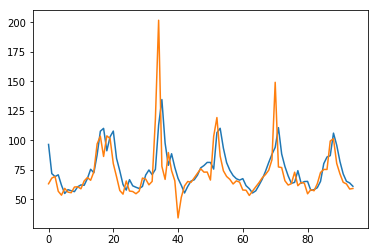

In [0]:
# Lets plot the actual vs predicted results of the model

pred_sub = predictions[1:96]
yTest_sub = np.array(yTest[1:96])

#yTest_sub
#pred_sub
plt.plot(pred_sub)
plt.plot(yTest_sub)
plt.show()

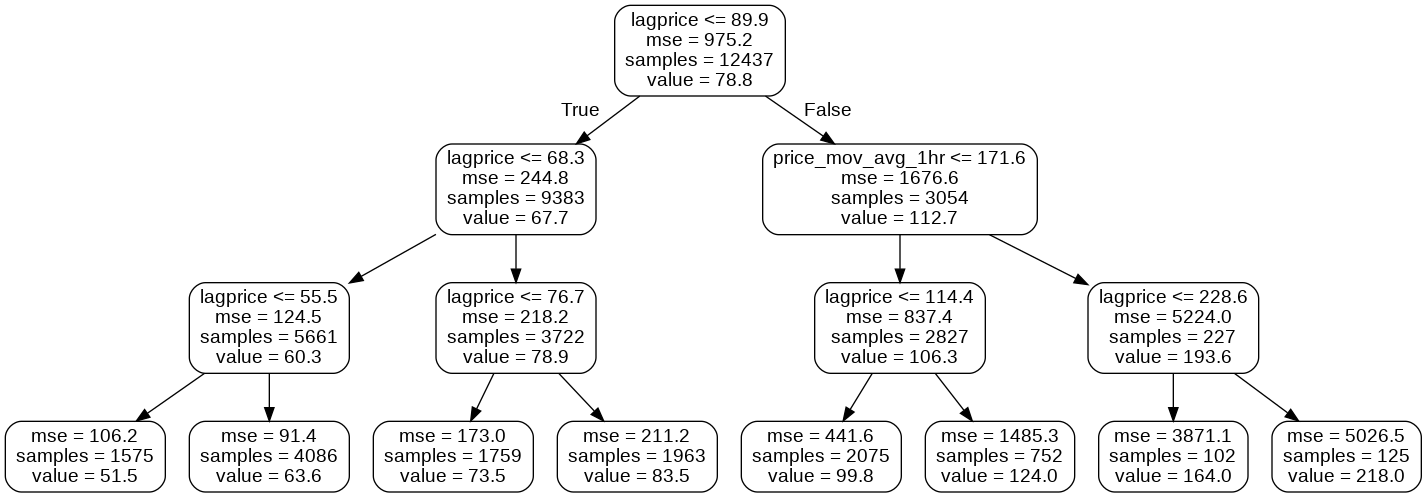

In [0]:
# Plot a tree from the forest with 3 levels 

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(xTrain, yTrain)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = list(x.columns), rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')


# Print the image from the working directory

from IPython.display import Image
Image('small_tree.png')

In [0]:
# Lets look at the feature importance

# Get numerical feature importances
importances = rf.feature_importances_


# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(x.columns), importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: lagprice             Importance: 0.29
Variable: price_mov_avg_1hr    Importance: 0.21
Variable: price_mov_avg_2hr    Importance: 0.17
Variable: TOTALDEMAND          Importance: 0.07
Variable: demand_mov_avg_1hr   Importance: 0.05
Variable: segment_30min        Importance: 0.05
Variable: Unnamed: 0           Importance: 0.04
Variable: demand_mov_avg_2hr   Importance: 0.04
Variable: Daily.global.solar.exposure..MJ.m.m. Importance: 0.02
Variable: Month                Importance: 0.01
Variable: Day                  Importance: 0.01
Variable: Minimum.temperature..Degree.C. Importance: 0.01
Variable: Maximum.temperature..Degree.C. Importance: 0.01
Variable: segment_day          Importance: 0.01
Variable: week_of_year         Importance: 0.01
Variable: Rainfall.amount..millimetres. Importance: 0.0
Variable: Season               Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 1.0, 'Variable Importances')

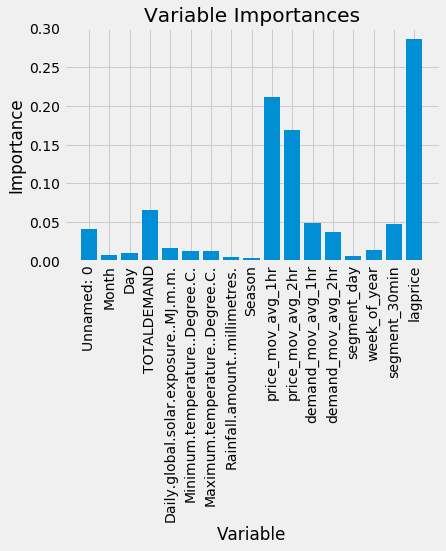

In [0]:
# Lets look at variable importance graphs

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, list(x.columns), rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

## Random Search Hyperparameter Tuning

In [0]:
# Hyperparameter tuning

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [0]:
# Use the random grid to search for best hyperparameters. First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, n_jobs = -1)

In [0]:
# Now retrain the random forest on the hyperparameter tuned model
rf_random.fit(xTrain, yTrain)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 31.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [0]:
# View the best parameters
#rf_random.best_params_


# Run a new random forest on the randomly selected best parameters

rf = RandomForestRegressor(bootstrap =  True, max_depth = 90, max_features = 'sqrt', min_samples_leaf = 4, min_samples_split = 2, n_estimators = 2000)

# Train the model on training data
rf.fit(xTrain, yTrain)

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 2000}

In [0]:
# Mark predictions on the test set

# Use the forest's predict method on the test data
predictions = rf.predict(xTest)

# Calculate the absolute errors
#errors = abs(predictions - yTest)

# Calculate the RMSE based on formula definition
np.sqrt(((predictions - yTest) ** 2).mean()) #27.0866

27.086614813989076

In [0]:
# Lets calculate the accuracy of the model

# Calculate the absolute errors
errors = abs(predictions - yTest)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

  
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / yTest)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') #83.74 and MAE = 16.45

Mean Absolute Error: 16.45 degrees.
Accuracy: 83.74 %.


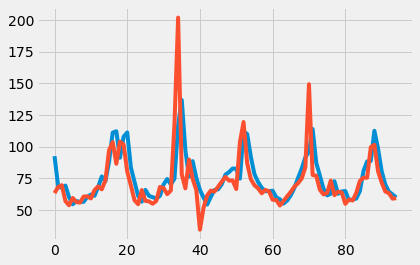

In [0]:
# Lets plot the actual vs predicted results of the model

pred_sub = predictions[1:96]
yTest_sub = np.array(yTest[1:96])

#yTest_sub
#pred_sub
plt.plot(pred_sub)
plt.plot(yTest_sub)
plt.show()

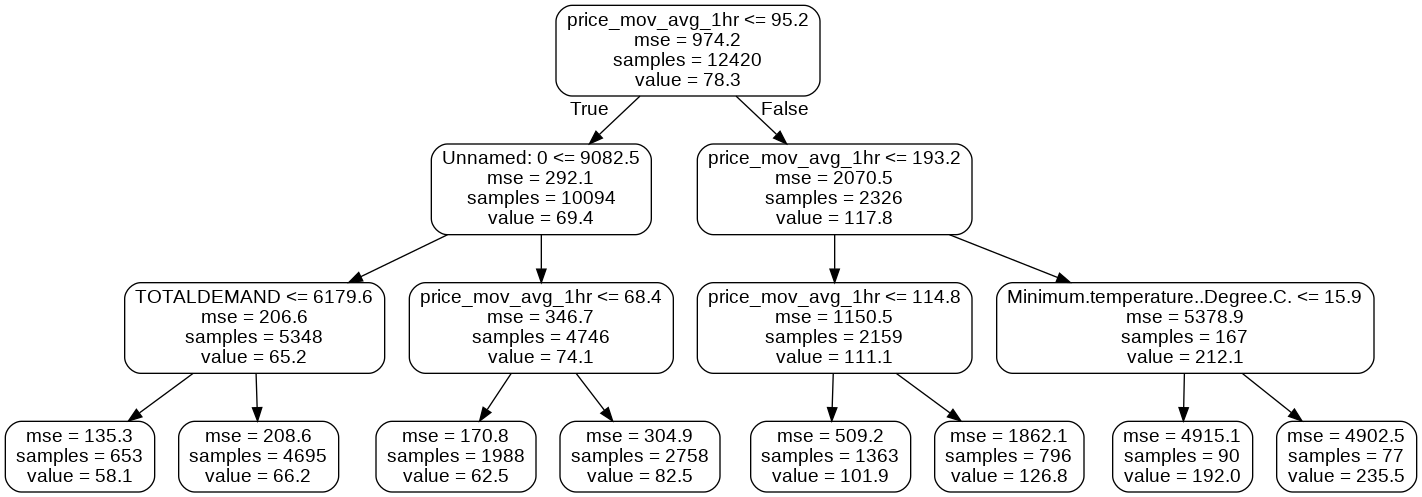

In [0]:
# Plot a tree from the forest with 3 levels 

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(bootstrap =  True, max_depth = 3, max_features = 'sqrt', min_samples_leaf = 4, min_samples_split = 2, n_estimators = 2000)
rf_small.fit(xTrain, yTrain)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = list(x.columns), rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree_rand.png')


# Print the image from the working directory

from IPython.display import Image
Image('small_tree_rand.png')

In [0]:
# Lets look at the feature importance

# Get numerical feature importances
importances = rf.feature_importances_


# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(x.columns), importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: lagprice             Importance: 0.3
Variable: price_mov_avg_1hr    Importance: 0.23
Variable: price_mov_avg_2hr    Importance: 0.16
Variable: TOTALDEMAND          Importance: 0.06
Variable: demand_mov_avg_1hr   Importance: 0.04
Variable: demand_mov_avg_2hr   Importance: 0.04
Variable: segment_30min        Importance: 0.04
Variable: Unnamed: 0           Importance: 0.03
Variable: Daily.global.solar.exposure..MJ.m.m. Importance: 0.02
Variable: Month                Importance: 0.01
Variable: Day                  Importance: 0.01
Variable: Minimum.temperature..Degree.C. Importance: 0.01
Variable: Maximum.temperature..Degree.C. Importance: 0.01
Variable: segment_day          Importance: 0.01
Variable: week_of_year         Importance: 0.01
Variable: Rainfall.amount..millimetres. Importance: 0.0
Variable: Season               Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 1.0, 'Variable Importances')

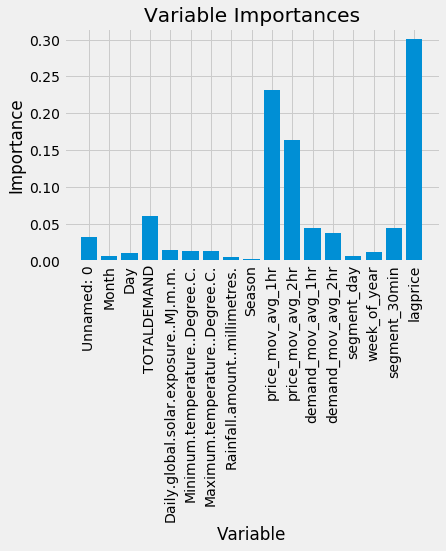

In [0]:
# Lets look at variable importance graphs

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, list(x.columns), rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

##Grid Search with Cross Validation

In [0]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(xTrain, yTrain)

grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 62.4min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 84.5min finished


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

In [0]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Train the model with 1000 decision trees initially
rf = RandomForestRegressor( bootstrap= True, max_depth=110, max_features= 3, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 200)

# Train the model on training data
rf.fit(xTrain, yTrain)


#{'bootstrap': True,
# 'max_depth': 110,
# 'max_features': 3,
# 'min_samples_leaf': 4,
# 'min_samples_split': 10,
# 'n_estimators': 200}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=110,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
# Mark predictions on the test set

# Use the forest's predict method on the test data
predictions = rf.predict(xTest)

# Calculate the absolute errors
#errors = abs(predictions - yTest)

# Calculate the RMSE based on formula definition
np.sqrt(((predictions - yTest) ** 2).mean()) #27.29

27.29280468790294

In [0]:
# Lets calculate the accuracy of the model

# Calculate the absolute errors
errors = abs(predictions - yTest)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

  
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / yTest)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') #83.58 and MAE = 16.56

Mean Absolute Error: 16.56 degrees.
Accuracy: 83.58 %.


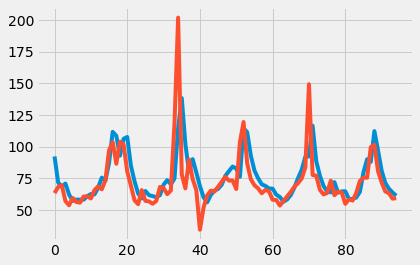

In [0]:
# Lets plot the actual vs predicted results of the model

pred_sub = predictions[1:96]
yTest_sub = np.array(yTest[1:96])

#yTest_sub
#pred_sub
plt.plot(pred_sub)
plt.plot(yTest_sub)
plt.show()

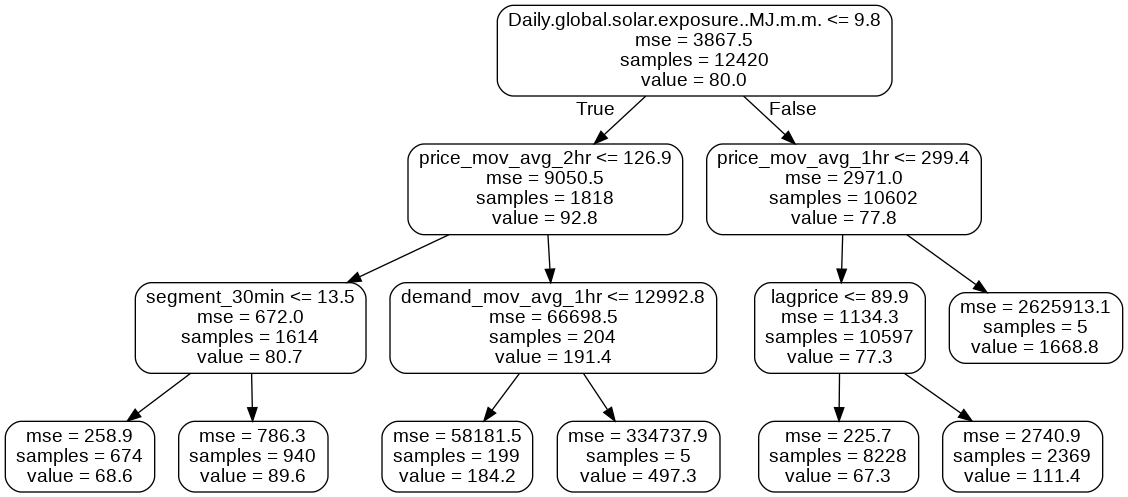

In [0]:
# Plot a tree from the forest with 3 levels 

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(bootstrap= True, max_depth=3, max_features= 3, min_samples_leaf= 5, min_samples_split= 10, n_estimators= 200)
rf_small.fit(xTrain, yTrain)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = list(x.columns), rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree_cv.png')


# Print the image from the working directory

from IPython.display import Image
Image('small_tree_cv.png')

In [0]:
# Lets look at the feature importance

# Get numerical feature importances
importances = rf.feature_importances_


# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(x.columns), importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]



Variable: lagprice             Importance: 0.29
Variable: price_mov_avg_1hr    Importance: 0.23
Variable: price_mov_avg_2hr    Importance: 0.15
Variable: TOTALDEMAND          Importance: 0.06
Variable: demand_mov_avg_1hr   Importance: 0.05
Variable: demand_mov_avg_2hr   Importance: 0.05
Variable: segment_30min        Importance: 0.05
Variable: Unnamed: 0           Importance: 0.04
Variable: Daily.global.solar.exposure..MJ.m.m. Importance: 0.02
Variable: Month                Importance: 0.01
Variable: Day                  Importance: 0.01
Variable: Minimum.temperature..Degree.C. Importance: 0.01
Variable: Maximum.temperature..Degree.C. Importance: 0.01
Variable: Rainfall.amount..millimetres. Importance: 0.01
Variable: segment_day          Importance: 0.01
Variable: week_of_year         Importance: 0.01
Variable: Season               Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 1.0, 'Variable Importances')

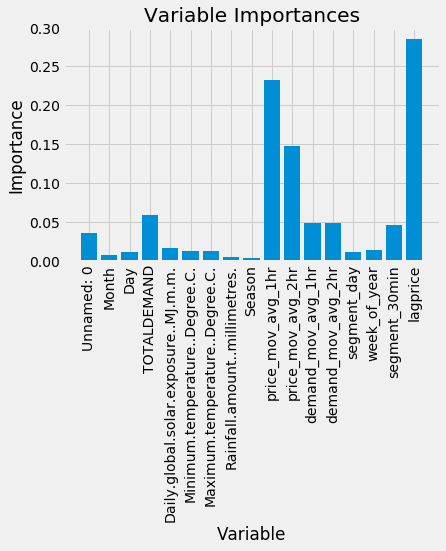

In [0]:
# Lets look at variable importance graphs

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, list(x.columns), rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

In [0]:
# Relative importance plot 

importances = forest.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
